# A step by step guide to extreme event atrribution

This notebook aims to provide code and explanations of how to undertake the risk-based approach to extreme event attribution as outlined in [Otto 2017](https://www.annualreviews.org/doi/full/10.1146/annurev-environ-102016-060847#_i2).  The code is intended to be illustrative starting points and a collection of useful tools.  In most cases it will need to be adapted for the invididual study in question.  Code elements supplied have been generated by a number of people and indivuidual authors are specified at the start of each python file in the git repository.  Please acknowledge use of this repository and relevant code contributors in any resulting publications.

The following code clones the repository into the notebook and installs the netCDF4 and cartopy packages required to run the example code provided.


In [ ]:
# Ensure in the correct directory and previous repository clones are removed
%cd /content
%rm -fr Attribution_workshop

# Clone the Attribution workshop repo.
!git clone -l -s  https://github.com/snsparrow/Attribution_workshop.git Attribution_workshop

# Change directory into cloned repo
%cd Attribution_workshop

# List repo contents
!ls

# Install the netCDF4 library
!pip -q install netCDF4

#Install the cartopy library
!apt-get -qq install python-cartopy python3-cartopy

# What is attribution?

Within attribution the occurrence of extreme weather events are compared between different climate model simulations run with different forcing conditions.

There are several possible outcomes from extreme event attribtuion studies:


*   The change in forcing *increased* the liklihood of the 
event occurring
*   The change in forcing *decreased* the liklihood of the event occurring
*   The change in forcing *did not have a detectable role* in the event occurrence.
*   Our analysis methods were *unable to give information*.

In general we use attribution to quantify either the effect of climate change is having on the likelihood of currently observed extreme weather events or how the likelihood (and magnitude) of damaging extremes may change under future climate scenarios.  However this technique can in principle be applied more generally to quantify the changes that other forcings may have on the climate system.

# Step 1: What happened?
Decide on the event (and variable you are interested in).  Is the event extreme in terms of the meteorology or the impacts?  Observations, re-analysis data and reports on the impacts will be useful.

As part of this it is often necessary to look at observations of the event and ascertain how unusual the particular event is compare to a longer historical record.  Individual station data or satellite data can be used for this or alternatively re-analysis datasets such as ERA5 or NCEP. 

In practice it may be a good idea to compare multiple different data sources. [Climate Explorer](https://climexp.knmi.nl/start.cgi) is a useful source of different available data products and allows easy visualisation of datasets.

The `plot_timeseries.py` code provided here will read in a 1D monthly mean dataset (in the example ERA5 data) and plot: (a) the distribution of values (b) timeseries with linear trend fit (c) the mean and variance annual cycle with individual years in grey and the selected year of interest highlighted in black. (d) the return time with the threshold and return period for the selected year highlighted.

Several command line arguments can be used with this code as follows:

*   `fname ` to specfy the filename including path of the 1D data
*   `variable` to specify the variable name in the data file
*   `year` to specify the year of interest to be highlighted
*   `--dirn` to specify the direction of the variable.  'descending' for a variable where the threshold is exceeded (default) and 'ascending' where the threshold is less than a given value.
*   `--start_month` to specify the start month of interest in the distribution and return time plot (default 'Jan')
*   `--end_month` to specify the start month of interest in the distribution and return time plot (default 'Dec')


In [ ]:
!git pull
!python plot_timeseries.py --fname="example_data/Cerrado_mean_MM_FWI_1979-2019.nc" --variable="fwi" --year=2015 --start_month='Sep' --end_month='Oct'

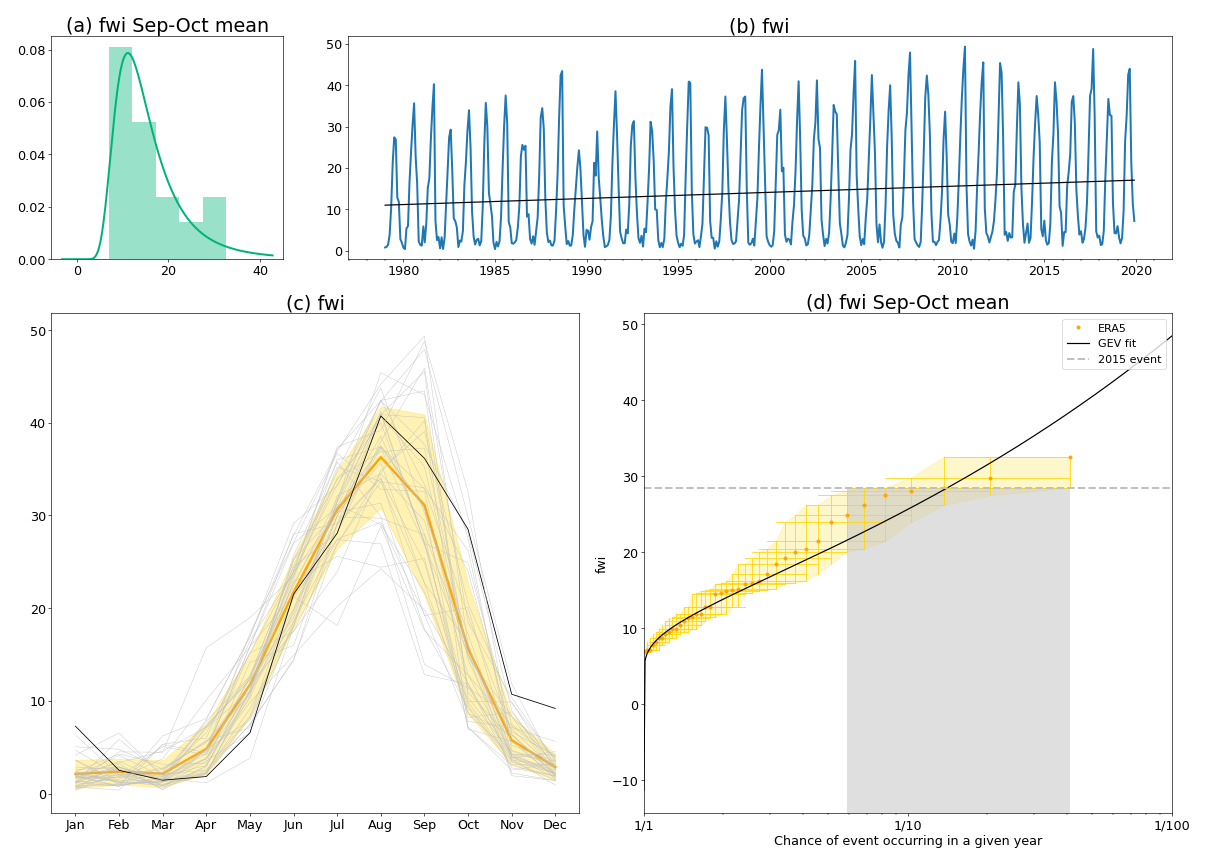

In [ ]:
from IPython.display import Image
Image('/content/Attribution_workshop/Timeseries_analysis_fwi.png')

This code can be modified to look at the max or min values over the selected months or use different frequency input data.  Comments have been added to indicate where these changes may be required. 

# Step 2: Event definition

This is often the hardest part of extreme event attribution.  The event should be well observed in space and time.  There is often tension between the impact (which are localised) and good signal to noise ratio and representation in climate models (large scale).  

In general the aim is to define the event so that it is representative of a *class* of similar type events.  These should be defined in terms of:


*   The **timescale** associated with this class of event.  
*   The **spatial scale** associated with this class of event.

Remember if the definition is too specific then almost be definition the event you are looking at will be the most extreme.  It may be useful to consider:


*   Do you expect the model to simulate the extreme on exactly the same days as observed? (Most likely no). Would it have been less impactful if the event happened a week or month earlier/later than observed? Sometimes it can be useful to define the event in terms of say the maximum value over a month (or season), or the maximum 5-day period in a month.
*   Would the event have been more/less impactful if it occurred in a slightly different region or covered a different area? i.e. we need to region considered to be large enough. Thinking about the nature of the impacts may be helpful with  this. Often for high precipitation or flooding events this task is easier and the event region may be defined in terms of the catchment area of the river.

As mentioned above, when defining the event it may be necessary to mask data to a given shapefile region. Whether that is the shape of a particular river catchment area or a particular country or state, or a region covered by a particular service provider will be determined by your particular study question. 

With this in mind the `create_masks_shp.py` code may be useful to convert a vectorised shapefile into a gridded dataset mask that can then be applied to your model output data. Both the shapefile and a template grid file (as NetCDF) is supplied and NetCDF mask files are generated for each layer in the shapefile. Several command line arguments can be used with this code as follows:

*   `f_grid` to specify the netcdf file (including path) that acts as a template file for the desired grid of the mask (required).
*   `shapefile` to specify the shapefile (including path) to convert to a netcdf mask of the template file dimensions.
* `shapefield` to specify the shapefile field definitions used to select individual layers. (Note the code prints out these out when run so can be determined from that if unknown)
* `template_var` to specify the name of the field in the template grid netcdf file to be used as the template variable.
* `latname` the name of the latitude dimension in the template netcdf file (default "lat")
* `lonname` the name  of the longitude dimension in the template netcdf file (default "lon")
* `field_list` optionally specify a subset of layers in the shapefile to produce masks for (default None which outputs masks for all layers).


In [ ]:
!git pull
!python create_masks_shp.py --f_grid "example_data/grid_template.nc" --shapefile "example_data/Brazil_biomes/Brazil_biomes.shp" --shapefield "name" --template_var "fwi" --latname "latitude" --lonname "longitude" --field_list "Cerrado" "Caatinga"

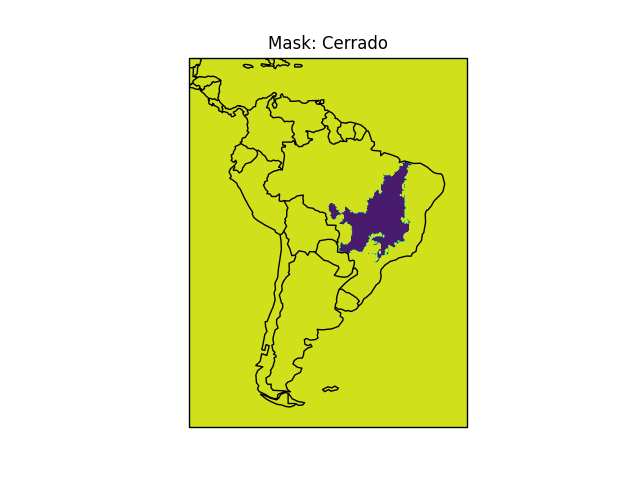

In [ ]:
from IPython.display import Image
Image('/content/Attribution_workshop/plots/mask_Cerrado.png')

This code creates netcdf mask files in the masks_netcdf directory (which is created) and plots of the mask regions in the plots directory (also created).  These netcdf mask files can then be used within CDO (climate data opereators) to filter data to the desired region.  

In some cases it may be necessary to merge multiple features on a shapefile layer.  An example of how to do this with ogr2ogr on the command line (making the appripriate substitution in angled brackets) is:

`ogr2ogr <output>.shp <input>.shp -dialect sqlite -sql "SELECT ST_Union(geometry) AS geometry FROM <layer_name>"`

**Note** before applying the mask it may be necessary to set 0 values to missing so they are not included in any averaging.  This can be done using the following cdo command (here mask_Cerrado.nc is used as the example file):

`cdo setctomiss,0 mask_Cerrado.nc mask_Cerrado_miss.nc`


Remember **event definition is key** and will frame the attribution question being asked.  Different framings can yield very different results.

# Step 3: Model evaluation

It is important when evaluating the model to use a common grid resolution to the observations and a common evaluation time period so historical climatologies can be compared.

Firstly, assess the statistical performance of the model.  In the simplest form this can be a comparison of the distributions over the historical climatology period, with perhaps inclusion of a Kolmogorov–Smirnov (K-S) test to check for statistical equality of the distributions (note example code for performing a K-S test can be found in `plot_return_time_PR.py`.

In addition quantile-quantile (Q-Q) plots can be produced to compare on a quantile by quantile basis the model and observational results.  These plots may also inform us of any first order bias corrections that need to be applied. The `q_q_plot.py` code produces a Q-Q plot and takes the following command line arguments:

- `obs_var` is the variable name of the field in the obseration data file
- `model_var` is the variable name of the field in the model data file
-  `obs_file` is the file name (including path) to the observation data file
- `model_file` is the file name (including path) to the model data file
- `plot_title` is the tile given to the Q-Q plot



In [ ]:
!git pull
!python q_q_plot.py --obs_var="precip" --model_var="pr" --obs_file="example_data/Minas_Gerais_1981-2013_CHIRPS.nc" --model_file="example_data/Minas_Gerais_1981-2013_HadGEM_all.nc" --plot_title="Precipitation (mm/day)"

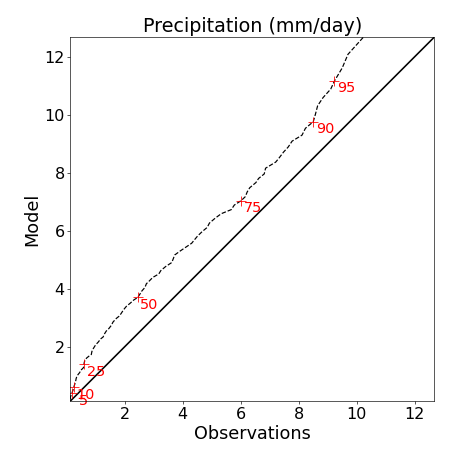

In [17]:
from IPython.display import Image
Image('/content/Attribution_workshop/precip_q_q_plot.png')

Bias correction can be complicated and detailed description of bias correction techniques are outside of the scope of this notebook, however interested readers may find further insights in [Sippel et al 2016](https://www.earth-syst-dynam.net/7/71/2016/) and [Bellprat et al 2019](https://www.nature.com/articles/s41467-019-09729-2).

For more extensive evaluation, tools such as the [ESMValTool ](https://www.esmvaltool.org)are recommended, which is a community tool for diagnostic performance metrics.

# Step 4: Estimate liklihoods

As outlined in [Otto 2017](https://www.annualreviews.org/doi/full/10.1146/annurev-environ-102016-060847#_i2) there are broadly three different (and worthy) methodological approaches to extreme event attribution:

**Risk-based approach** (described here)

*   Simulates large ensembles of the event in a factual and counter factual world and compares threshold exceedance whilst reproducing the extreme event statistics. 
*   Aims to answer whether and to what extent anthropogenic climate change has changed the occurrence frequency of an event. 

**Mechanistic approach**

*   Analyses an individual extreme event and its predictability from large-scale circulation patterns isolating different causal factors that may be acting.
*   Aims to disentangle different causal factors leading to the event without necessarily quantifying the influence of these causal factors on the likelihood of occurrence.
* Causal inference techniques such as Response Guided - Causal Precursor Detection [(RG-CPD)](https://github.com/semvijverberg/RGCPD) which relies on packages such as  [Tigramite](https://jakobrunge.github.io/tigramite/) are useful tools for investigating causal factors.

**Circulation-based approaches**

*   Defines the extreme event by its circulation state and calculates analogs from reanalysis or models. The change of occurrence of analog states is then assessed. The use of self-organising maps can be useful to classify circulation states.
*   The storyline approach conditions the analysis on the atmospheric circulation state and (incorporating elements of the mechanistic approach) seeks to identify physically self-consistent, plausible pathways with the aim of reframing the questions from the prediction space into the decision space.





**Risk-based approach example**

The `plot_return_time_PR.py` code calculates the return times and probability ratios (PR) with uncertainties. There are 3 views (i) the return time curve (ii) the PR as a function of return time (iii) the PR as a function of threshold. Note that the uncertainty bounds on the PR calculation can be lengthy and so there is an option to restore (or if omitted calculate and save) intermediate files. 

Several command line arguments can be used with this code as follows:
- `fname_act` to specify the actual/historical data file (including path)to be read (or restored from a numpy save file).
- `fname_nat` to specify the natural/historicalNat data file (including path)to be read (or restored from a numpy save file).
- `variable` the variable name
- `threshold` the threshold value for the highlighted event onn the figure produced
- `restore` to restore the actual, natural and pre-calculated PR ratios from numpy save files.  When omitted the acutal/natural data is read and the PR with uncertainties (which can be lengthy) calculated.

In [9]:
!git pull
!python plot_return_time_PR.py --fname_act='example_data/dataHist_HadGEM_Tmax_2017_allT.npy' --fname_nat='example_data/dataNat_HadGEM_Tmax_2017_allT.npy' --variable='Tx5x' --threshold=34.5 --restore

Already up to date.
Historical GEV fit, K-S test parameters p: 0.941809218621011 D: 0.023113618572835226
HistoricalNat GEV fit, K-S test parameters p: 0.6516593016820079 D: 0.032098569000158006
plot_return_time_PR.py:146: RuntimeWarning: divide by zero encountered in true_divide
  PR=probAct/probNat
plot_return_time_PR.py:185: RuntimeWarning: divide by zero encountered in true_divide
  PR=probAct/probNat
PR median (5% 95%): 7.7058823529411775 5.333333333333333 12.454545454545455
Finished!


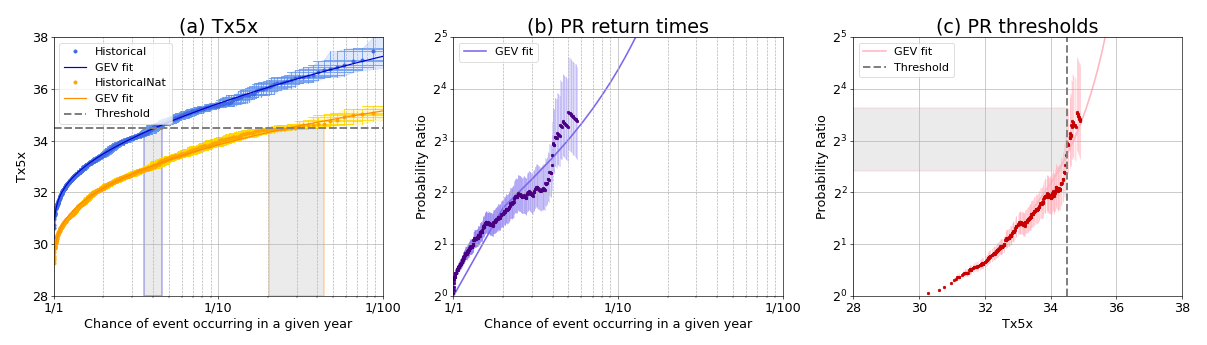

In [8]:
from IPython.display import Image
Image('/content/Attribution_workshop/Return_time_PR_Tx5x.png')

# Step 5: Interpret and synthesise

This is where all the information is brought together using as many different methods and data sources as possible to provide a consensus result considering a broad picture.  Here is it important to be mindful of differences in data resolution, coverage, model representation and ensemble size as well as any differences in experimental design which could impact your results.  Be sure to where possible make fair comparisons. How can results based on different models/observations be combined, summarised and presented?

Go back and consider your original motivation for studying this event.  How can this analysis provide meaningful information for communities and stakeholders?  How could this analysis be further used by the impact community for adaptation and mitigation efforts. 

# Step 6: Communication

As well as publishing and promoting any academic publications of your attribution research, it is also worth considering if more direct stakeholder and/or public communication is appropriate so that decision making can be appropriately informed.

Key questions to consider are:


*   What is the information that stakeholders want?
*   How can we present this in a meaningful way?
*   Where are the vulnerabilities?


As part of this it is also good practice to ensure that where possible any new data generated within studies is documented and made openly available, ideally adopting FAIR (Findable, Accessible, Interoperable and Reproducable) data principles.